<font size="5">Libraries</font>

In [437]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

<font size="5">Let's examine the data</font>

In [441]:
df = pd.read_csv('GOOG.csv') #2004-2024

In [443]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512


In [445]:
# Extract "Date" and "Close" feature columns from the dataframe for this project
df = df[['Date', 'Close']]

In [447]:
df.head()

,Date,Close
0,2004-08-19,2.499133
1,2004-08-20,2.697639
2,2004-08-23,2.724787
3,2004-08-24,2.611960
4,2004-08-25,2.640104


In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024 entries, 0 to 5023
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5024 non-null   object 
 1   Close   5024 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.6+ KB


In [451]:
df['Date'].min(), df['Date'].max() #display time period of data

('2004-08-19', '2024-08-05')

<font size="5">Quick Visual</font>

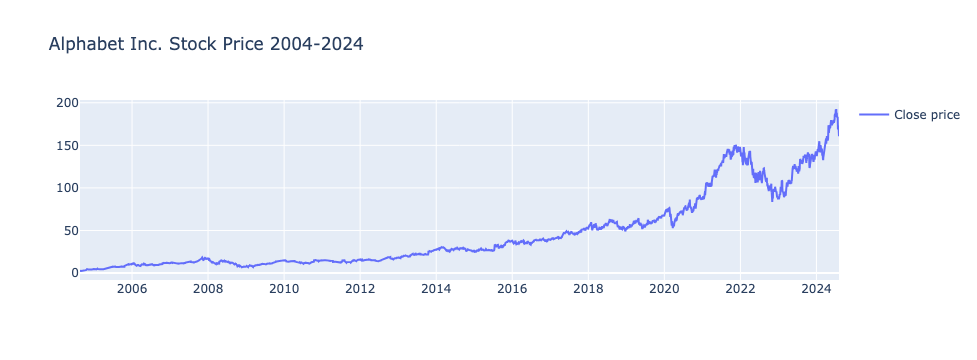

In [453]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Alphabet Inc. Stock Price 2004-2024')
fig.show()

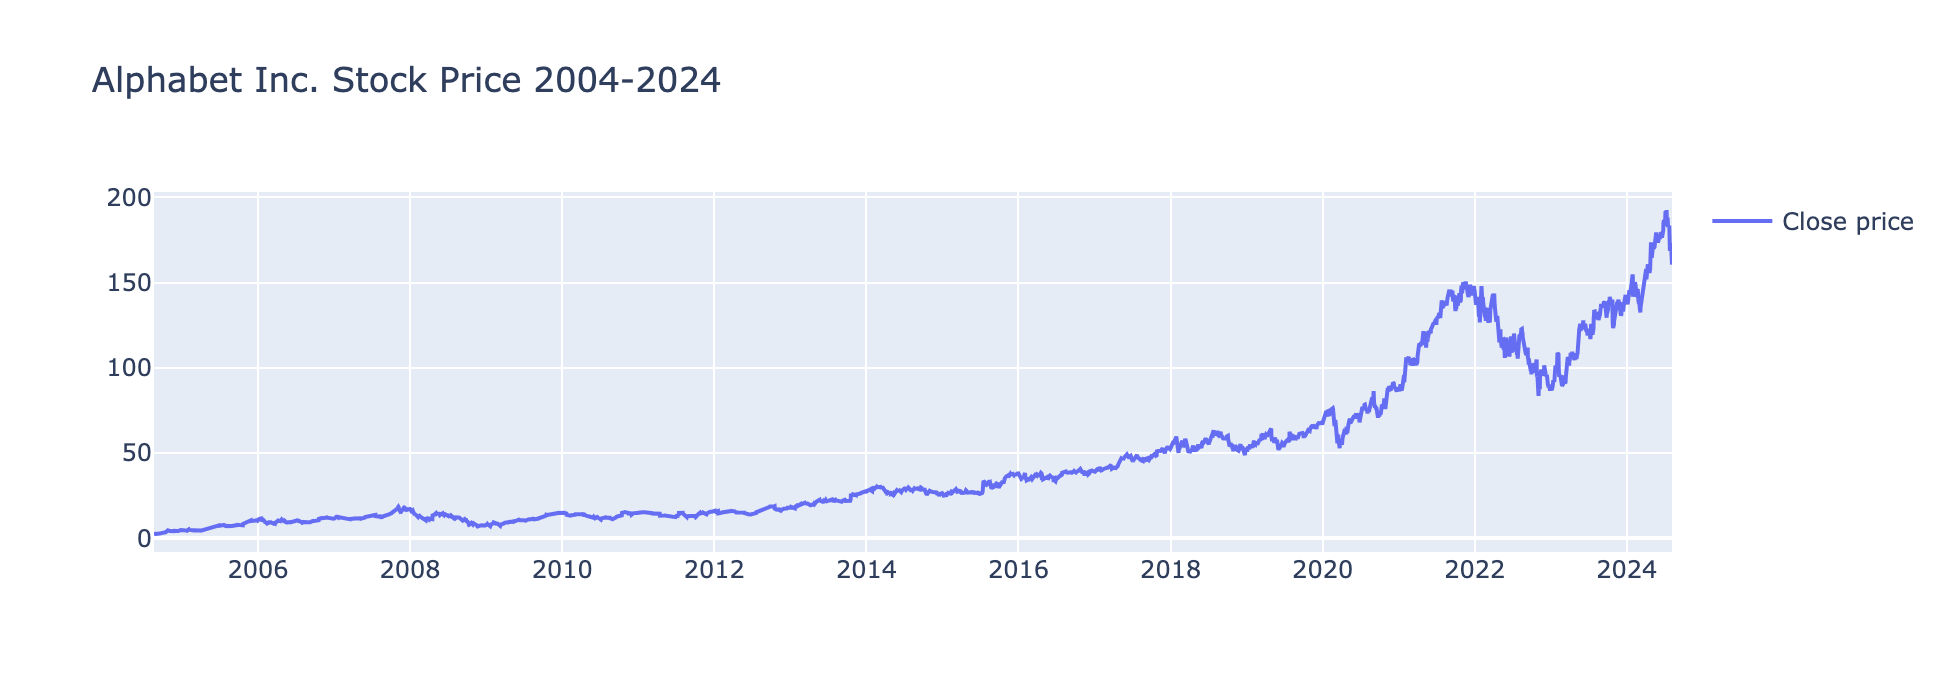

<font size="5">Preprocessing</font>

In [457]:
from sklearn.model_selection import train_test_split
#train-test split, half of data in train, half in test
start_date = '2004-08-19'
end_date = '2024-08-05'
df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Split the filtered DataFrame into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Display the resulting DataFrames
print("Train set:")
print(train)
print("\nTest set:")
print(test)

Train set:
            Date       Close
2095  2012-12-13   17.501900
3997  2020-07-07   74.259003
3859  2019-12-17   67.755997
1491  2010-07-22   12.074990
88    2004-12-23    4.679958
...          ...         ...
4426  2022-03-18  136.801498
466   2006-06-26   10.067764
3092  2016-11-29   38.542000
3772  2019-08-14   58.214500
860   2008-01-18   14.950213

[4019 rows x 2 columns]

Test set:
            Date       Close
1504  2010-08-10   12.545726
538   2006-10-06   10.473244
4989  2024-06-14  178.369995
4949  2024-04-18  157.460007
4820  2023-10-12  140.289993
...          ...         ...
2244  2013-07-19   22.331297
1592  2010-12-14   14.817211
4655  2023-02-15   97.099998
3973  2020-06-02   71.960999
150   2005-03-24    4.464516

[1005 rows x 2 columns]


In [459]:
train = df.loc[df['Date'] <= '2020-08-24'] #80% of data 
test = df.loc[df['Date'] > '2020-08-24'] #20% of data 
train.shape, test.shape

((4032, 2), (992, 2))

In [461]:
# more accuracte way to split the data into train/test
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(4772, 2) (252, 2)


In [463]:
#Data Scaling

# Initialize the StandardScaler to compute the mean and standard deviation
scaler = StandardScaler()

# Fit the scaler to the 'Close' column of the training data and transform it
scaler = scaler.fit(np.array(train['Close']).reshape(-1, 1)) #reshapes it into 1 column, many rows(-1)

# Standardize the 'Close' column in the training data
train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1, 1))

# Standardize the 'Close' column in the testing data using the same scaler
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1, 1))

/Users/Rudu/anaconda3/envs/anomalydetection/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Rudu/anaconda3/envs/anomalydetection/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



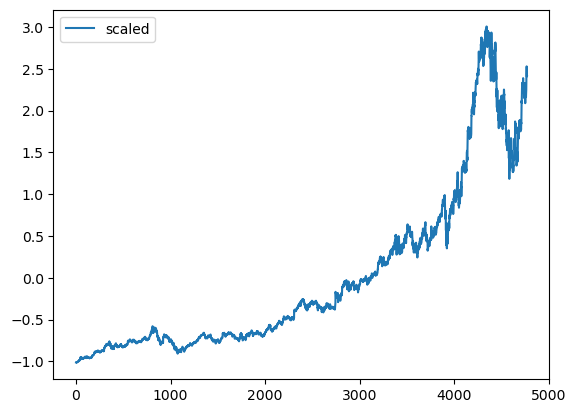

In [465]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [467]:
#Create sequences combining TIME_STEPS contiguous data values from the training data.
#TIME_STEP/sequence length is set at 30 as we want our network to have memory of 30 days.

# Define the number of time steps (sequence length) for the data
TIME_STEPS = 30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []  # Initialize lists to store input sequences and corresponding outputs
    
    # Loop through the dataset to create sequences of specified time steps(30)
    for i in range(len(X) - time_steps):
        # Append a sequence of 'time_steps' data points as input
        X_out.append(X.iloc[i:(i + time_steps)].values)
        # Append the value immediately following the sequence as the output
        y_out.append(y.iloc[i + time_steps])
    
    # Convert lists to numpy arrays
    return np.array(X_out), np.array(y_out)

# Create training sequences from the 'Close' column in the training data
X_train, y_train = create_sequences(train[['Close']], train['Close'])

# Create testing sequences from the 'Close' column in the testing data
X_test, y_test = create_sequences(test[['Close']], test['Close'])

# Print the shape of the training input data to confirm it has the expected shape
print("Training input shape: ", X_train.shape)  # should be sets of 30 values
print("Testing input shape: ", X_test.shape)    

Training input shape:  (4742, 30, 1)
Testing input shape:  (222, 30, 1)


In [469]:
X_train[4741]

array([[2.20818091],
       [2.2789529 ],
       [2.25590439],
       [2.14933969],
       [2.1471706 ],
       [2.20330008],
       [2.17428629],
       [2.20031733],
       [2.18919981],
       [2.24532927],
       [2.19923267],
       [2.17781125],
       [2.08914304],
       [2.11192011],
       [2.1637112 ],
       [2.30498394],
       [2.32857445],
       [2.31122044],
       [2.28464717],
       [2.24939668],
       [2.16127068],
       [2.18242089],
       [2.2249925 ],
       [2.24966789],
       [2.43595279],
       [2.44164685],
       [2.52679013],
       [2.52950186],
       [2.49642066],
       [2.40829465]])

In [471]:
# set seed for each generator to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

<font size="5">LSTM Autoencoder model</font>

In [473]:
#We are trying to build an LSTM Autoencoder model
#The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. 
#In this case, sequence_length is 30 and num_features is 1

# Define a Sequential model for time series data with LSTM layers
model = Sequential()

# Add an LSTM layer with 128 units and 'tanh' activation function.
# The input shape is (sequence_length, num_features), where sequence_length is 30 and num_features is 1.
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dropout layer with a dropout rate of 0.2 to prevent overfitting.
model.add(Dropout(rate=0.2))

# Add a RepeatVector layer to repeat the output of the previous LSTM layer 'sequence_length' times(30).
# This is necessary to prepare the data for the next LSTM layer, which expects sequences of the same length.
model.add(RepeatVector(X_train.shape[1]))

# Add another LSTM layer with 128 units and 'tanh' activation function.
# Set return_sequences=True to output the full sequence, which is needed for the TimeDistributed layer.
model.add(LSTM(128, activation='tanh', return_sequences=True))

# Add a Dropout layer with a dropout rate of 0.2 to further prevent overfitting.
model.add(Dropout(rate=0.2))

# Add a TimeDistributed layer with a Dense layer inside.
# The TimeDistributed layer applies the Dense layer to each time step individually.
# The Dense layer has output units equal to the number of features in the input (num_features)(1).
model.add(TimeDistributed(Dense(X_train.shape[2])))

# Compile the model using the Adam optimizer with a learning rate of 0.001 and mean squared error (mse) as the loss function.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Print the summary of the model to view its architecture and parameters
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_14 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_27 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_27 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

<font size="5">Train the model</font>

In [475]:
# Train the model
history = model.fit(
    X_train,                            # Input data for training
    y_train,                            # Target data for training
    epochs=100,                         # Number of epochs to train the model
    batch_size=32,                      # Number of samples per gradient update (batch size)
    validation_split=0.1,               # Fraction of data to reserve for validation (10% of the training data)
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],  # Callback to stop training early if no improvement in 5 epochs
    shuffle=False                       # do not shuffle as the data is history dependent
)


Epoch 1/100
134/134 [==============================] - 9s 37ms/step - loss: 0.0426 - val_loss: 0.4152
Epoch 2/100
134/134 [==============================] - 4s 27ms/step - loss: 0.0222 - val_loss: 0.0612
Epoch 3/100
134/134 [==============================] - 3s 25ms/step - loss: 0.0169 - val_loss: 0.0613
Epoch 4/100
134/134 [==============================] - 3s 25ms/step - loss: 0.0131 - val_loss: 0.0649
Epoch 5/100
134/134 [==============================] - 4s 29ms/step - loss: 0.0142 - val_loss: 0.0631
Epoch 6/100
134/134 [==============================] - 4s 27ms/step - loss: 0.0140 - val_loss: 0.0881
Epoch 7/100
134/134 [==============================] - 5s 34ms/step - loss: 0.0075 - val_loss: 0.1602


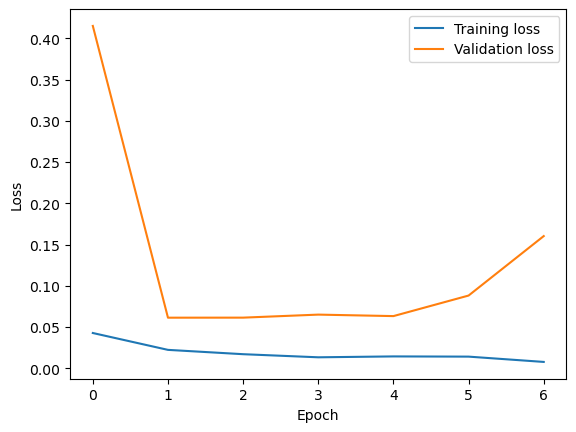

In [477]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Not great, let's modify our autoencoder model and increase our batch size

In [480]:
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]), 
               kernel_regularizer=regularizers.l2(0.01), 
               recurrent_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.3))  # Increased dropout rate
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.3))  # Increased dropout rate
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse")  # Lower learning rate

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')  # Increased patience

history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=64,  # Adjust batch size
    validation_split=0.1,
    callbacks=[early_stopping],
    shuffle=False
)


Epoch 1/25
67/67 [==============================] - 3s 27ms/step - loss: 0.6722 - val_loss: 0.7047
Epoch 2/25
67/67 [==============================] - 1s 21ms/step - loss: 0.3694 - val_loss: 0.5426
Epoch 3/25
67/67 [==============================] - 1s 21ms/step - loss: 0.2256 - val_loss: 0.3896
Epoch 4/25
67/67 [==============================] - 2s 24ms/step - loss: 0.1878 - val_loss: 0.2893
Epoch 5/25
67/67 [==============================] - 3s 48ms/step - loss: 0.1268 - val_loss: 0.2661
Epoch 6/25
67/67 [==============================] - 2s 22ms/step - loss: 0.1073 - val_loss: 0.2164
Epoch 7/25
67/67 [==============================] - 1s 22ms/step - loss: 0.0803 - val_loss: 0.1947
Epoch 8/25
67/67 [==============================] - 3s 40ms/step - loss: 0.0708 - val_loss: 0.1720
Epoch 9/25
67/67 [==============================] - 2s 24ms/step - loss: 0.0606 - val_loss: 0.1601
Epoch 10/25
67/67 [==============================] - 1s 21ms/step - loss: 0.0541 - val_loss: 0.1482
Epoch 11/

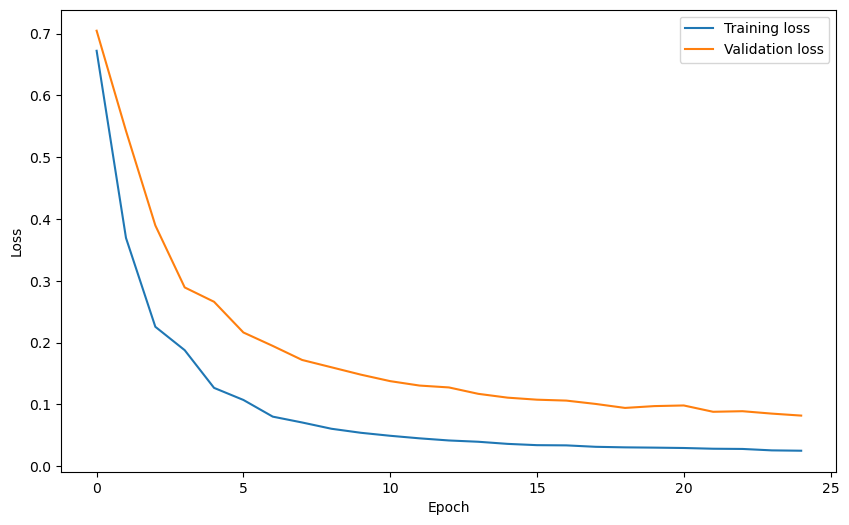

In [482]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

149/149 [==============================] - 1s 5ms/step


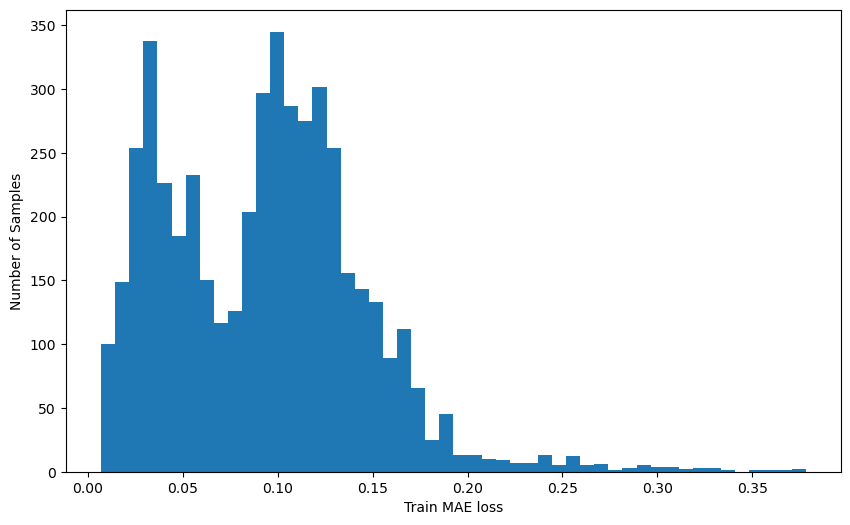

Reconstruction error threshold: 0.3780962983273698


In [488]:
# Mean Absolute Error loss, autoencoder tries to replicate
# Predict the output of the training data using the trained model
X_train_pred = model.predict(X_train)

# Calculate the Mean Absolute Error (MAE) for each sample in the training data
# by taking the absolute difference between the predicted and actual values, then averaging across features
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Create a histogram to visualize the distribution of the MAE losses for the training data
plt.figure(figsize=(10,6))
plt.hist(train_mae_loss, bins=50)  # Plot histogram with 50 bins
plt.xlabel('Train MAE loss')        
plt.ylabel('Number of Samples')      
plt.show()                           

# Set the reconstruction error threshold to the maximum MAE loss value observed in the training data
threshold = np.max(train_mae_loss) #anything above would be an anomaly

print('Reconstruction error threshold:', threshold)


<font size="4">Here's another way to plot the MAE loss in Seaborn:</font>

149/149 [==============================] - 1s 5ms/step


/Users/Rudu/anaconda3/envs/anomalydetection/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




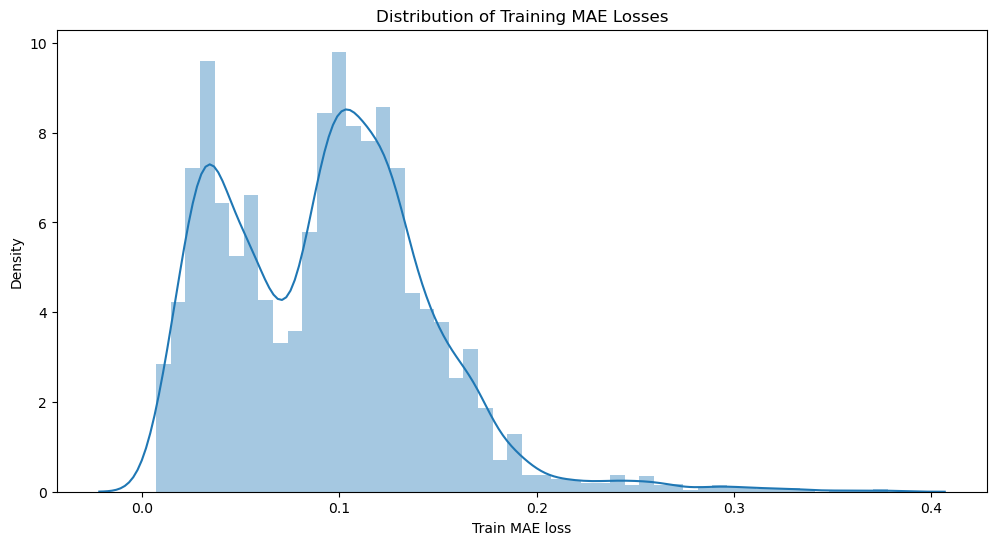

In [486]:
import seaborn as sns

# Predict the output of the training data using the trained model
X_train_pred = model.predict(X_train)

# Calculate the Mean Absolute Error (MAE) for each sample in the training data
# by taking the absolute difference between the predicted and actual values, then averaging across features
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Create a distribution plot of the MAE losses for the training data
# `kde=True` adds a Kernel Density Estimate curve to the plot
plt.figure(figsize=(12,6))  # Increase the width of the plot
sns.distplot(train_mae_loss, bins=50, kde=True)

plt.xlabel('Train MAE loss')  
plt.ylabel('Density')          
plt.title('Distribution of Training MAE Losses')  
plt.show()  # Display the plot

7/7 [==============================] - 0s 6ms/step


Text(0, 0.5, 'Number of samples')

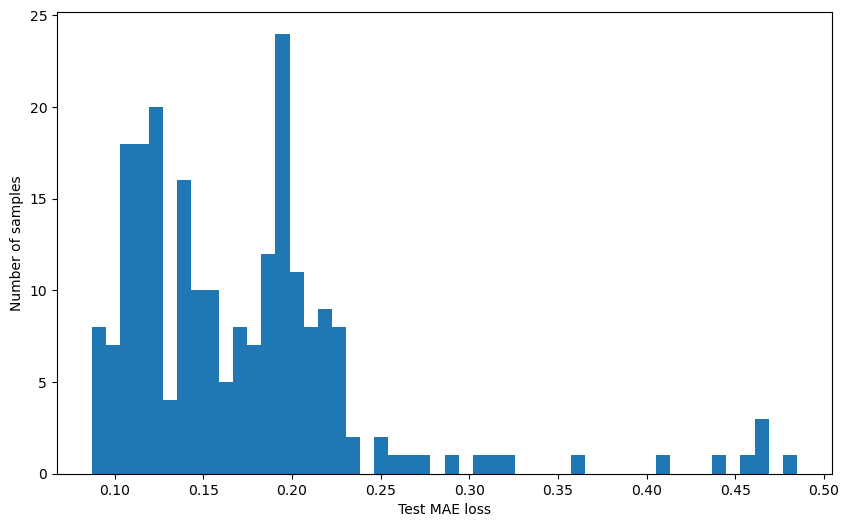

In [490]:
# Let's predict the anomalies on test data using our threshold()

# Predict outputs for the test data
X_test_pred = model.predict(X_test, verbose=1)

# Calculate the mean absolute error (MAE) for each test sample
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Create a histogram to visualize the distribution of MAE losses
plt.figure(figsize=(10,6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')  
plt.ylabel('Number of samples')  

In [492]:
# Create a DataFrame from the test data, excluding the first TIME_STEPS entries
anomaly_df = pd.DataFrame(test[TIME_STEPS:])

# Add a column for the MAE loss values
anomaly_df['loss'] = test_mae_loss

# Add a column for the predefined threshold values
anomaly_df['threshold'] = threshold

# Determine if each sample is an anomaly based on whether the loss exceeds the threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [494]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
4802,2023-09-18,2.688129,0.117962,0.378096,False
4803,2023-09-19,2.684604,0.122292,0.378096,False
4804,2023-09-20,2.569633,0.121684,0.378096,False
4805,2023-09-21,2.482049,0.110146,0.378096,False
4806,2023-09-22,2.479067,0.107345,0.378096,False


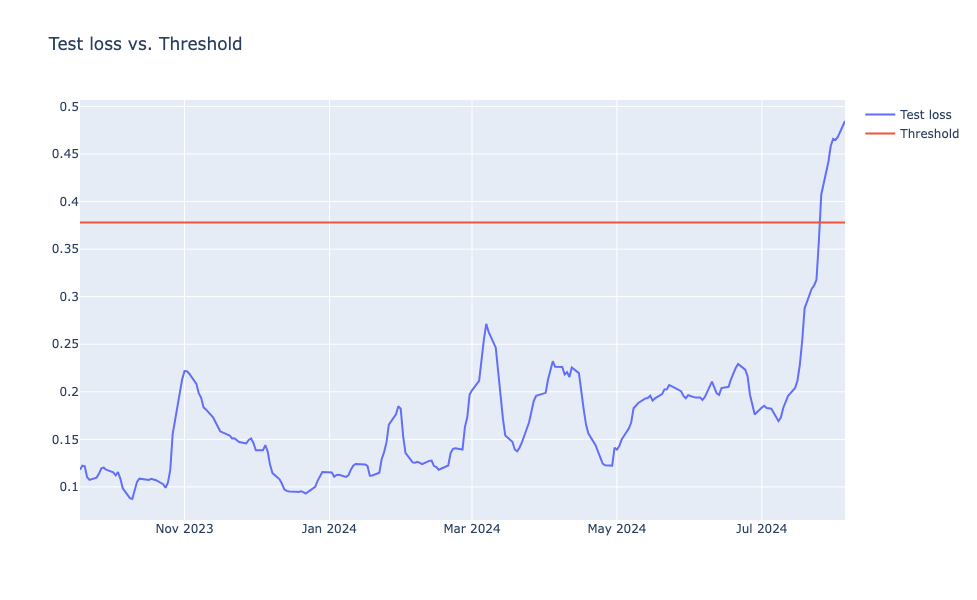

In [496]:
# Create an interactive plot using Plotly to visualize the comparison between test loss and threshold values over time.
# This plot will help in analyzing how test losses compare with the threshold values and identify any anomalies.

import plotly.graph_objects as go

fig = go.Figure()

# Add a trace for the test loss data
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))

# Add a trace for the threshold data
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))

fig.update_layout(
    showlegend=True,  
    title='Test loss vs. Threshold',  
    width=950, 
    height=600,  
)

fig.show()

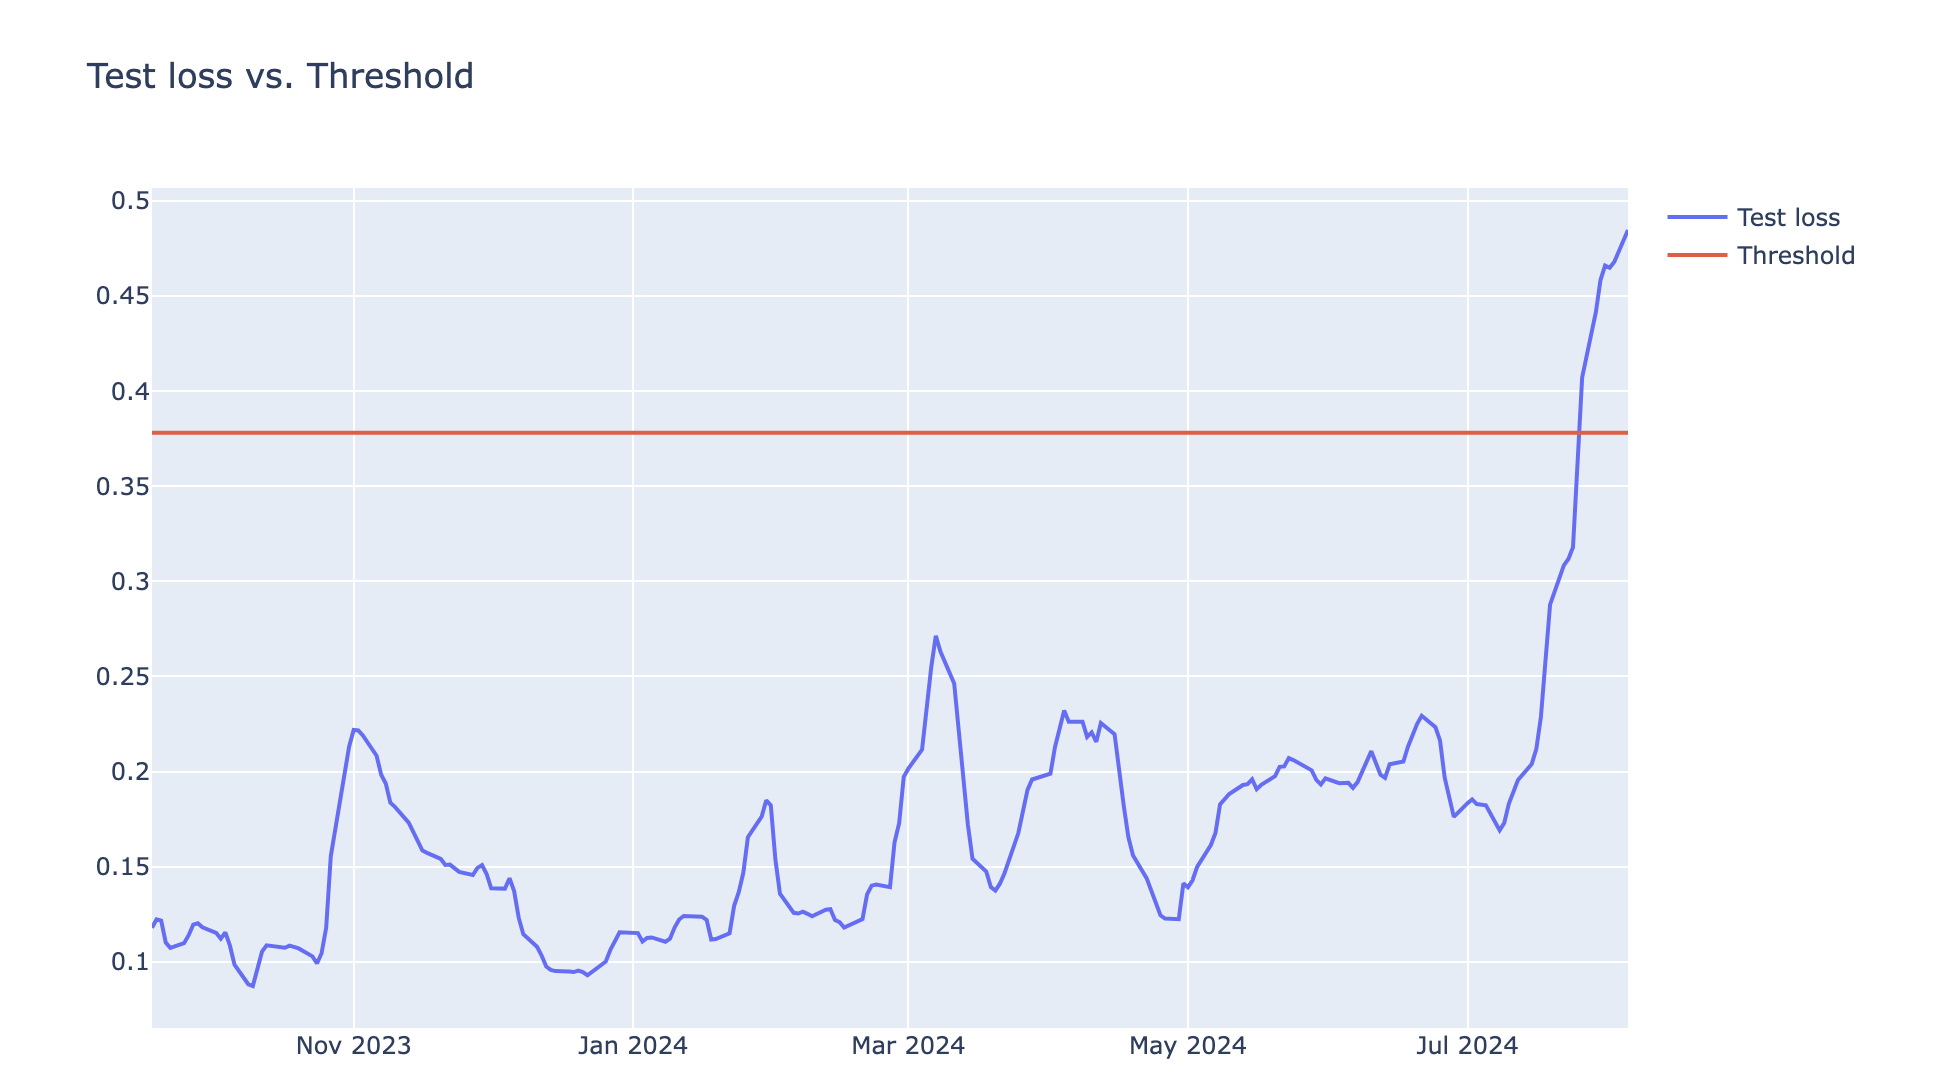

In [498]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
5017,2024-07-26,3.494007,0.407198,0.378096,True
5018,2024-07-29,3.560441,0.441592,0.378096,True
5019,2024-07-30,3.580235,0.458383,0.378096,True
5020,2024-07-31,3.615214,0.465960,0.378096,True
5021,2024-08-01,3.596233,0.464805,0.378096,True


In [500]:
anomalies.shape

(7, 5)

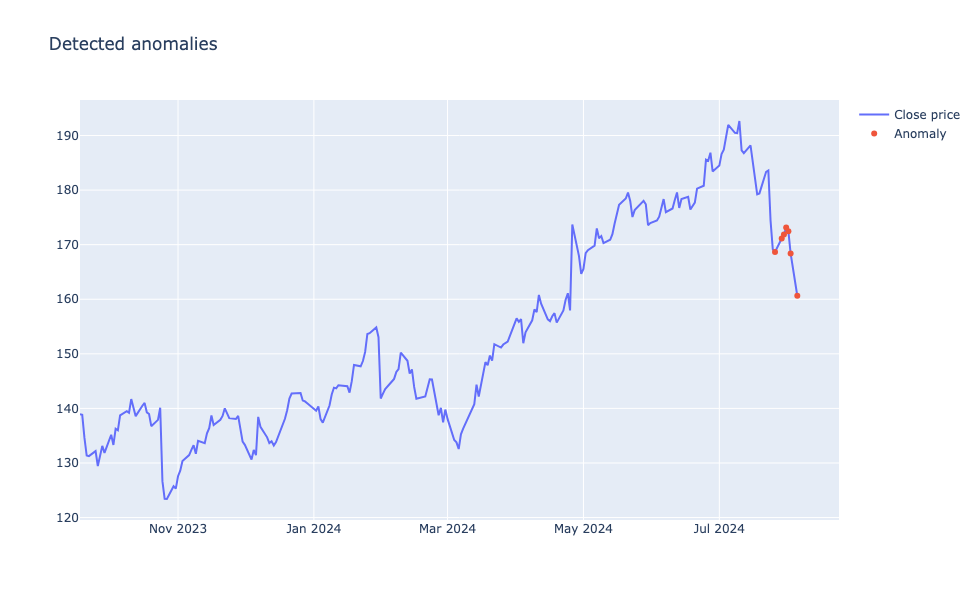

In [502]:
# Create an interactive plot using Plotly to visualize close prices and detected anomalies.
# The plot displays the close prices and highlights the anomalies, allowing for a clear view of where anomalies occur in the data.

import plotly.graph_objects as go

# Reshape the 1D arrays of close prices into 2D arrays for compatibility with the scaler
X_train_close_reshaped = anomaly_df['Close'].values.reshape(-1, 1)
anomalies_close_reshaped = anomalies['Close'].values.reshape(-1, 1)

fig = go.Figure()

# Add a trace for the close price data
fig.add_trace(go.Scatter(
    x=anomaly_df['Date'], 
    y=scaler.inverse_transform(X_train_close_reshaped).flatten(), 
    name='Close price'
))

# Add a trace for the anomalies, represented as markers
fig.add_trace(go.Scatter(
    x=anomalies['Date'], 
    y=scaler.inverse_transform(anomalies_close_reshaped).flatten(), 
    mode='markers', 
    name='Anomaly'
))

fig.update_layout(
    showlegend=True, 
    title='Detected anomalies',  
    width=950,  
    height=600,  
)

fig.show()


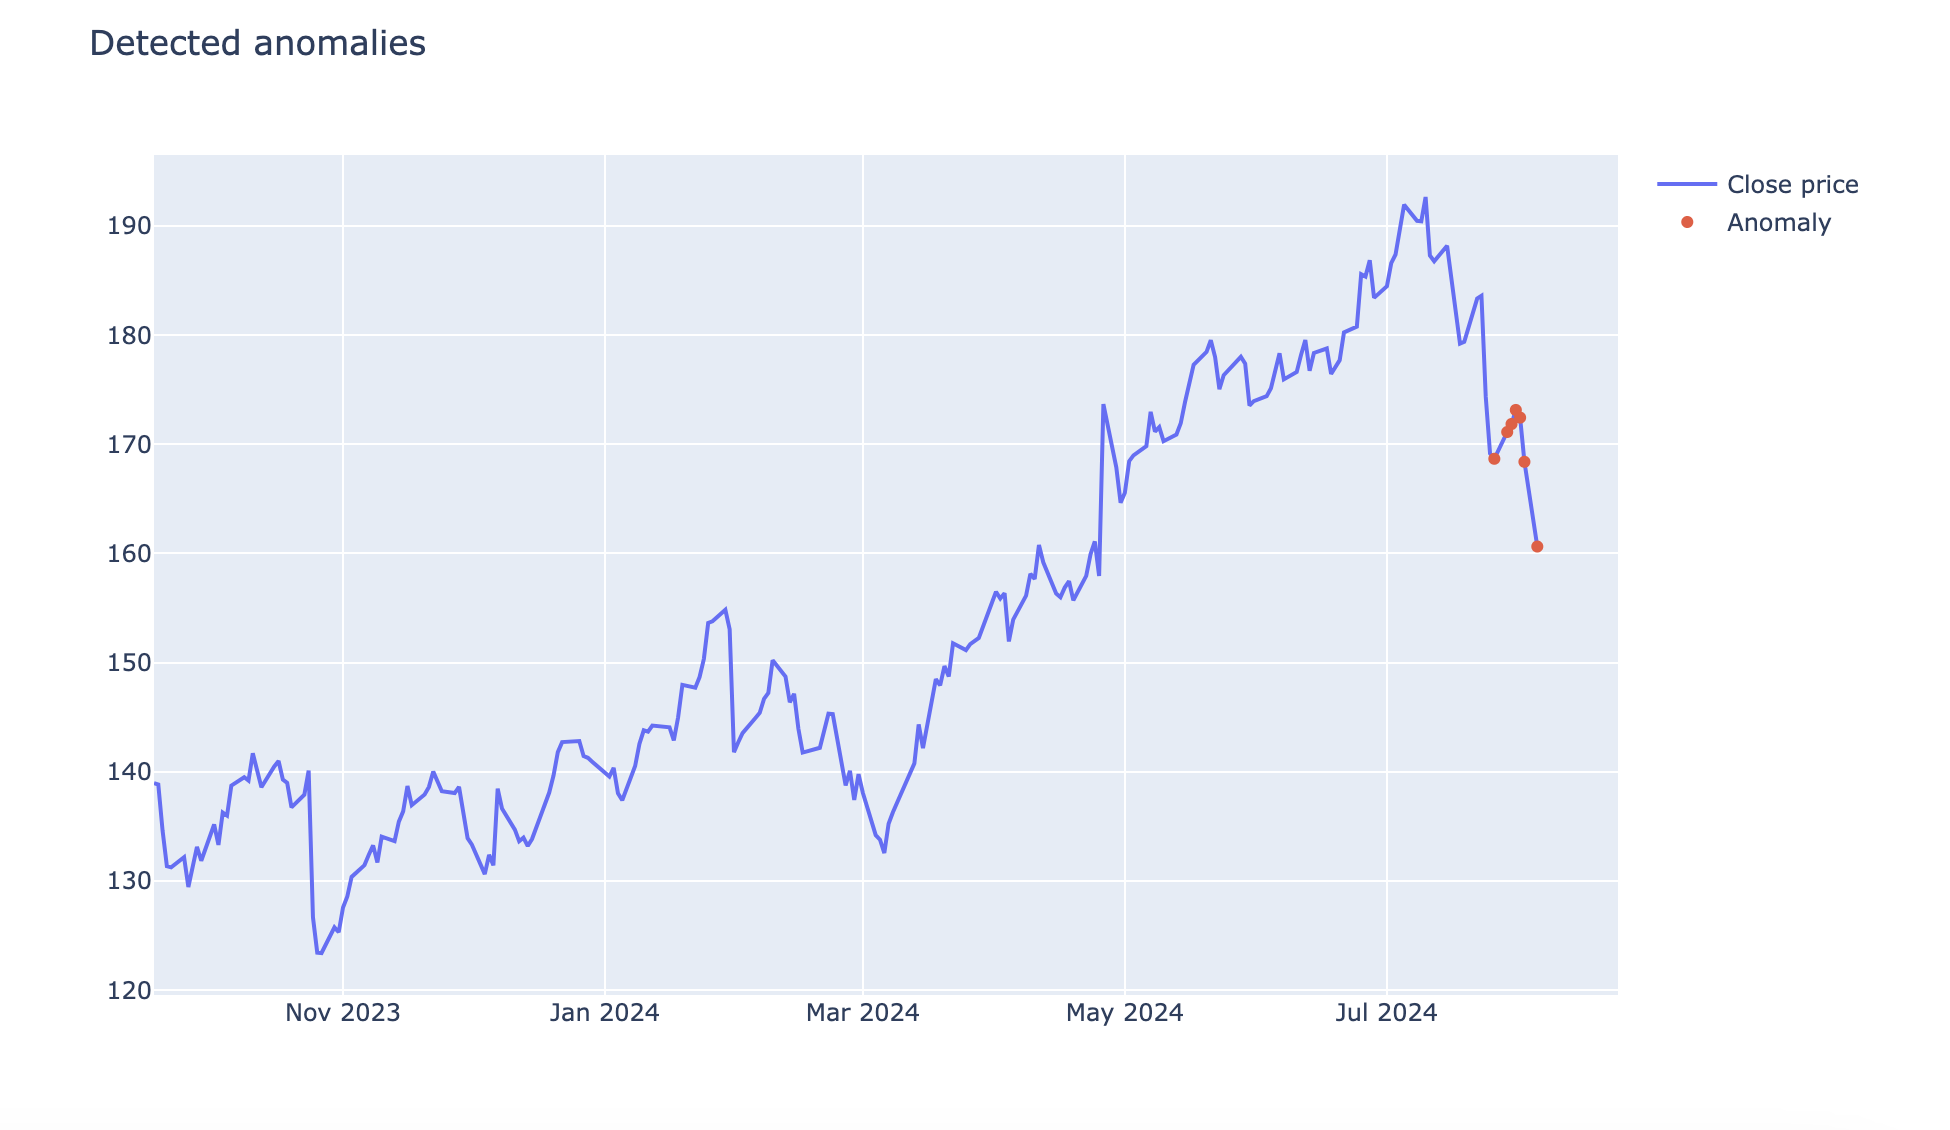

And now we have our anomalies!